# Import

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
import fourier_continuation as fc_c
import pickle as pickle
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (55, 55)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
#x_perc = (xi[shape[1]]-xi[0])*0.10
#y_perc = (yi[1]-yi[0])*0.10
#z_perc = (-zi[0])*0.10
#np.random.seed(10)
#noise_x = np.random.normal(0, x_perc, len(xi))
#noise_y = np.random.normal(0, y_perc, len(xi))
#noise_z = np.random.normal(0, z_perc, len(zi))
#xi = xi + noise_x
#yi = yi + noise_y
#zi = zi + noise_z

xi_plot, yi_plot, = xi/1000, yi/1000

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (55, 55)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 1000], [2000, 1000]]
verts2 = [[-4000, 1000], [0, 1000], [0, 3000], [-4000, 3000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[1,3,0]}),
               ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':[3,1,0]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':[2,2,2]})]

print (ft.utils_vec2ang([2,2,2]))

[3.4641016151377544, 35.264389682754654, 45.0]


In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(10.)
dec0 = np.deg2rad(37.)
inc = np.deg2rad(10.)
dec = np.deg2rad(37.)
#inc = np.deg2rad(0.)
#dec = np.deg2rad(45.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
data = []
delta_g = []
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
dobs_0 = tf_prism + tf_sphere
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

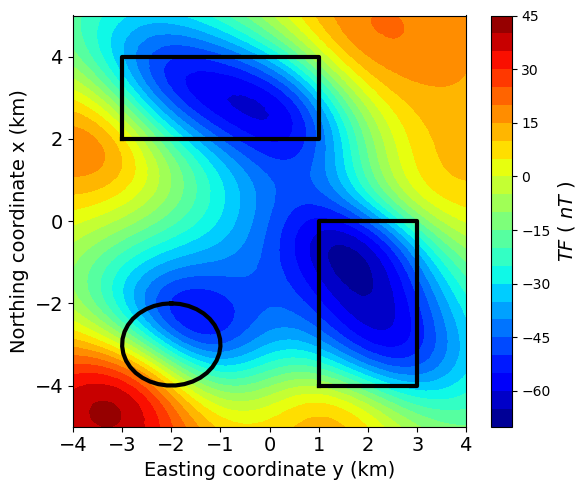

In [5]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [1, 1, 3, 3, 1]
y_p2 = [-4, 0, 0, -4, -4.]

fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,data[0],22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('model_mag_synthetic_extra.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [6]:
# Calculo da matriz de sensibilidade
delta_p_classical = []
p_0, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical.append(norm_pl)

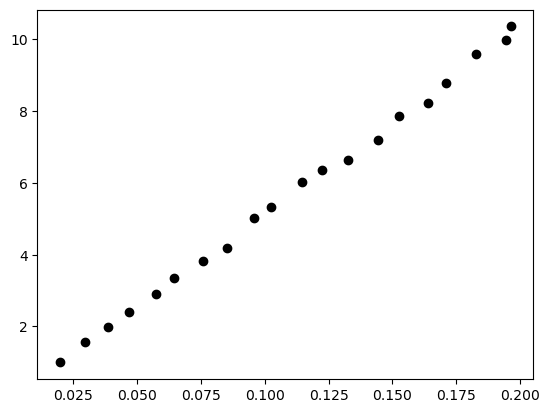

In [7]:
plt.plot(delta_g,delta_p_classical, 'ko')

### BCCB  matrix-vector product with Linear CGLS implementation

In [8]:
delta_p_BCCB = []
itmax = 50
p_bccb_0, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[0],F,h,itmax)
norm_p_bccb_0 = np.linalg.norm(p_bccb_0)
for i in range(len(data)-1):
    p_bccb, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[i+1],F,h,itmax)
    norm_p_c = np.linalg.norm(p_bccb-p_bccb_0)/norm_p_bccb_0
    delta_p_BCCB.append(norm_p_c)

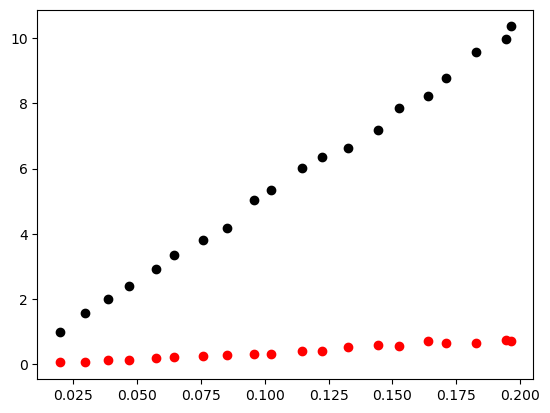

In [9]:
plt.plot(delta_g,delta_p_classical, 'ko')
plt.plot(delta_g,delta_p_BCCB, 'ro')

## Deconvolution

In [10]:
delta_p_dec = []
Hxx,Hxy,Hxz,Hyy,Hyz,Hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
cev = fc.ones_cev_mag(Hxx,Hxy,Hxz,Hyy,Hyz,Hzz,shape,N,F,h)
w = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
w = w.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
rho_c_0_dec = np.ravel(np.real(rho_c_0_dec[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for j in range(len(data)-1):
    w = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w = w.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
    rho_c_dec = np.ravel(np.real(rho_c_dec[:shape[1],:shape[0]]).T)
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution wiith Wiener stabilization

In [11]:
# Regularization factor of Wiener deconvolution
mu = 1e-10

delta_p_dec_wiener = []
Hxx,Hxy,Hxz,Hyy,Hyz,Hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
cev = fc.ones_cev_mag(Hxx,Hxy,Hxz,Hyy,Hyz,Hzz,shape,N,F,h)
w = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
w = w.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec_wiener = np.fft.ifft2((np.fft.fft2(w)*np.conj(cev))/(cev*np.conj(cev) + mu))
rho_c_0_dec_wiener = np.ravel(np.real(rho_c_0_dec_wiener[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)
for j in range(len(data)-1):
    w = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w = w.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec_wiener = np.fft.ifft2((np.fft.fft2(w)*np.conj(cev))/(cev*np.conj(cev) + mu))
    rho_c_dec_wiener = np.ravel(np.real(rho_c_dec_wiener[:shape[1],:shape[0]]).T)
    norm_rho_c_dec_wiener = np.linalg.norm(rho_c_dec_wiener-rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    delta_p_dec_wiener.append(norm_rho_c_dec_wiener)

## Straight line fits

In [12]:
coe = np.polyfit(delta_g, delta_p_classical, 1)
poly1d_fn = np.poly1d(coe)

coe2 = np.polyfit(delta_g, delta_p_BCCB, 1)
poly1d_fn2 = np.poly1d(coe2)

coe3 = np.polyfit(delta_g, delta_p_dec, 1)
poly1d_fn3 = np.poly1d(coe3)

coe4 = np.polyfit(delta_g, delta_p_dec_wiener, 1)
poly1d_fn4 = np.poly1d(coe4)

## Figure plots

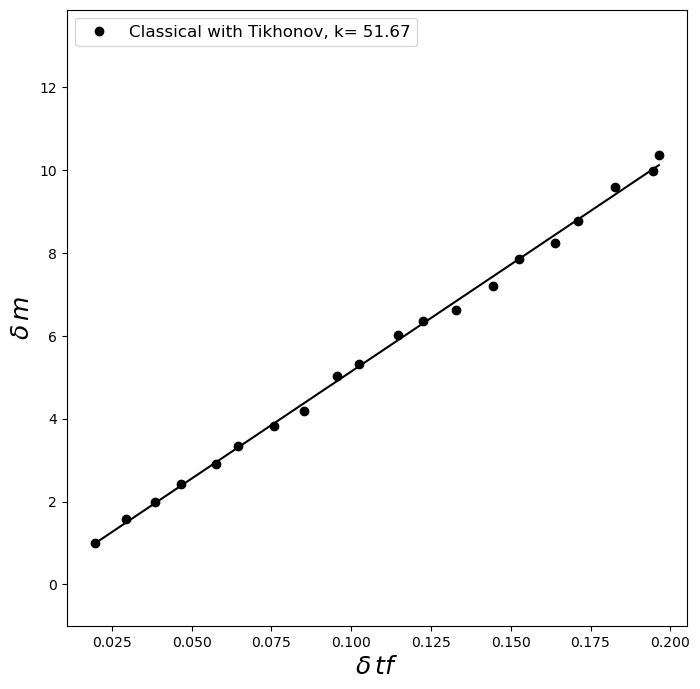

In [21]:
fig=plt.figure(figsize=(8,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(delta_g,delta_p_classical, 'ko', label='Classical with Tikhonov, k= %.2f' % (coe[0]))
plt.plot(delta_g,poly1d_fn(delta_g), 'k-')
#plt.plot(delta_g,delta_p_BCCB, 'ro', label='Convolutional eq. layer CGLS, k= %.2f' % (coe2[0]))
#plt.plot(delta_g,poly1d_fn2(delta_g), 'r-')
#plt.plot(delta_g,delta_p_dec, 'bo', label='Deconvolutional eq. layer, k= %.2f' % (coe3[0]))
#plt.plot(delta_g,poly1d_fn3(delta_g), 'b-')
#plt.plot(delta_g,delta_p_dec_wiener, 'go', label='Deconvolutional eq. layer with Wiener, k= %.2f' % (coe4[0]))
#plt.plot(delta_g,poly1d_fn4(delta_g), 'g-', linewidth=0.8)
plt.ylim(np.min(delta_p_dec_wiener)-1,np.max(delta_p_dec)+2)
plt.xlabel('$\delta \, tf$', fontsize=18)
plt.ylabel('$\delta \, m$', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
#plt.savefig('../../manuscript/Fig/stability_mag_1.png', dpi=300)

## Fit comparison

In [22]:
A = fc.sensibility_matrix(xi,yi,zi,zj,F,h,N)

tf_classic = np.dot(A,p)
tf_bccb = np.dot(A,p_bccb)
tf_dec = np.dot(A,rho_c_dec)
tf_dec_wiener = np.dot(A,rho_c_dec_wiener)

In [24]:
scale_max = np.max(tf_classic)
scale_min = np.min(tf_classic)

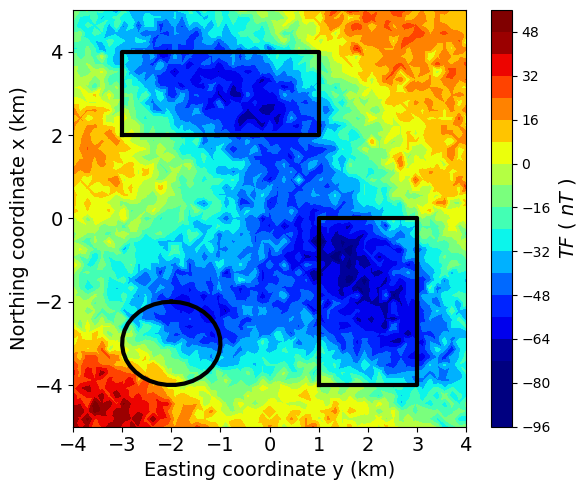

In [34]:
fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,data[-1],22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_mag_noise.png', dpi=300)

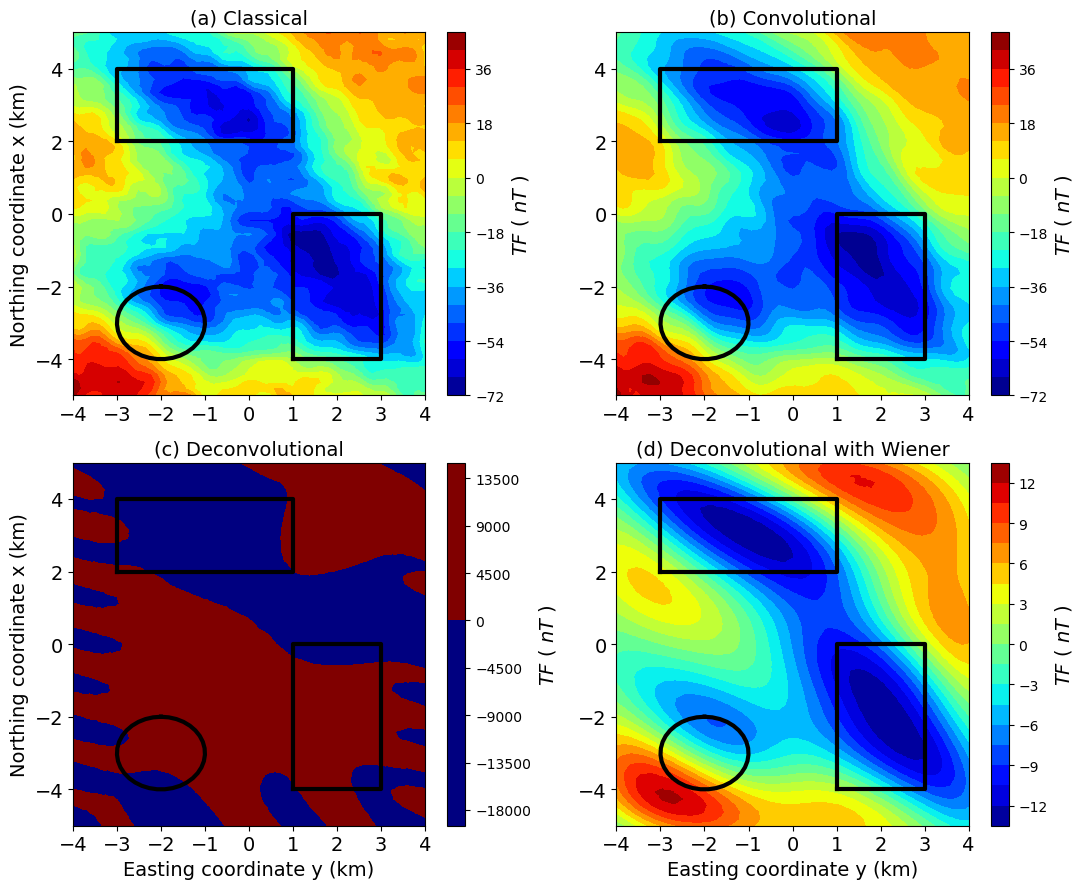

In [35]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [1, 1, 3, 3, 1]
y_p2 = [-4, 0, 0, -4, -4.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a) Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_classic,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b) Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c) Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d) Deconvolutional with Wiener', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/stability_mag_comparison.png', dpi=300)

In [ ]:
print (np.mean(np.abs(delta_tf_classical_down)), ('(Classical method)'))
print (np.mean(np.abs(delta_tf_bccb_down)), ('(Our method)'))
print (np.mean(np.abs(delta_tf_fourier_down)), ('(Fourier method)'))
print ()
print (np.std(np.abs(delta_tf_classical_down)), ('(Classical method)'))
print (np.std(np.abs(delta_tf_bccb_down)), ('(Our method)'))
print (np.std(np.abs(delta_tf_fourier_down)), ('(Fourier method)'))